# <center>MLB Pre-Pitch Type Prediction Modeling<center>
### <center>Ruslan Davtian<center>

In [5]:
import pandas as pd
import numpy as np
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from datetime import datetime
import warnings

from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, LeaveOneOut, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.pipeline import Pipeline

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
## Functions defined in this cell

# Function that given a dataframe, it displays the percentage of missing values for each column
def missing_values_table(df):
    miss_val = df.isnull().sum()
    miss_val_percent = 100 * df.isnull().sum() / len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table_ren_columns = miss_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    miss_val_table_ren_columns = miss_val_table_ren_columns[
        miss_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(miss_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return miss_val_table_ren_columns

def horz_stacked_bar_chart_perc(data, x_var, y_var, y_label, title):
    df_grouped = data.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    ax = df_grouped.plot.barh(stacked=True, figsize=(15,8))
    plt.legend(bbox_to_anchor=(0.5, 1.02),loc="best",borderaxespad=0,frameon=False,ncol=5,fontsize = 10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('Percentages', fontsize=18)
    plt.ylabel(y_label, fontsize=16)
    plt.title(title, fontsize = 18, loc='left')
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element > 0.02:
                plt.text(cumulative + element / 2,ix,f"{int(element * 100)} %",va="center",ha="center",fontsize=12)
                cumulative += element
                
# Function that given a dataframe, random sample nrow rows from 
def random_sample_df(df, nrow):
    return df.sample(nrow)


def model_pitch_type(data, numeric_inputs, category_inputs, model_type, metric, sample):
    
    df = data[[y for x in [numeric_inputs, category_inputs, ["pitch_name"]] for y in x]]
    df = df.reset_index()
    df = random_sample_df(df, sample)
    
    # Fix label Font Size for Confusion Table & Confusion Table Title
    plt.rcParams.update({'font.size': 16})
    titles_options = [("Confusion Matrix", None), ("Normalized Confusion Matrix", 'true')]


    # Create Dummy/Indicator Columns for Categorical Features
    for column in category_inputs:
        dummies = pd.get_dummies(df[column])
        df[dummies.columns] = dummies
        df = df.drop(labels = column, axis = 1)
        
    if (model_type != "XGB"):
        df = df.dropna()
    
    # 80,20 Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(df.drop(labels="pitch_name", axis=1), df["pitch_name"], 
                                                        test_size=0.2, random_state=0, stratify = df["pitch_name"])

    #y_train = y_train.iloc[:, 0]
    #y_test = y_test.iloc[:, 0]

    print('y_train dim: ', y_train.shape)
    print('X_train dim: ', X_train.shape)
    print('X_test dim: ', X_test.shape)
    print('y_test dim:', y_test.shape)
    print("Total Rows: ", X_train.shape[0] + X_test.shape[0])

    X_train2 = X_train.drop(labels=['index','pitcher_id'], axis=1)
    X_test2 = X_test.drop(labels=['index','pitcher_id'], axis=1)
    features = X_train2.columns
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test_actual_names = y_test
    y_test = le.fit_transform(y_test)
    
    # Hyperparameter Grid-Search Cross Val based on model type
    # Penalized/Regularized Logistic Regression, Random Forest, Support Vector Classifier, Kth Nearest Neighbors, 
    # Gradient Boosting Model (Ensemble), Extreme Gradient Boosting Model (Ensemble)
    if (model_type == "MultiClassLogisticRegression"):
        model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1, max_iter=1000)
        pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_lr]]) 
        grid_values = {'classifier__C': [0.0001,0.001,0.01,0.1,1,10,50,100,500,1000]}
        model = GridSearchCV(estimator = pipeline, param_grid = grid_values, cv = cv, scoring = metric, n_jobs = 4)
    
    elif (model_type == "RandomForestClassifier"):
        model_rf = RandomForestClassifier(random_state=1)
        pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_rf]]) 
        grid_values = {'classifier__bootstrap': [True], 'classifier__max_depth': [5, 10, 15, 20, 25, 30],
                       'classifier__max_features': ['sqrt'], 'classifier__min_samples_leaf': [1, 2, 4], 
                       'classifier__min_samples_split': [2, 5, 10],
                       'classifier__n_estimators': [50, 100, 200, 300, 400, 500]}
        model = RandomizedSearchCV(estimator = pipeline, param_distributions = grid_values, scoring = metric,
                                   n_iter = 5, cv = cv, verbose=2, random_state=1, n_jobs = 4)
        #model = GridSearchCV(model_rf, param_grid = grid_values, cv = cv, scoring= "roc_auc")
    elif (model_type == "SVC"):
        model_svc = SVC(random_state=1, max_iter=1000, probability=True)
        if (sampling == True):
            pipeline = Pipeline(steps = [['sampling', SMOTE(random_state=1)], ['scaler', StandardScaler()],
                                         ['classifier', model_svc]])
        else:
            pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_svc]]) 
        grid_values = [{'classifier__kernel': ['rbf'], 'classifier__gamma': [1e-3, 1e-4],'classifier__C': [1, 10, 100, 1000]},
                    {'classifier__kernel': ['linear'], 'classifier__C': [1, 10, 100, 1000]}]
        model = GridSearchCV(pipeline, param_grid = grid_values, cv = cv, scoring= metric)
        #model = RandomizedSearchCV(estimator = pipeline, param_distributions = grid_values, scoring = metric,
                                   #n_iter = 15, cv = cv, verbose = 2, random_state=1, n_jobs = 4)
    elif (model_type == "KNN"):
        model_knn = KNeighborsClassifier()
        pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_knn]]) 
        grid_values = {'classifier__n_neighbors': [i for i in range(1, 100, 2)], 'classifier__metric': ['euclidean','minkowski'], 
                      'classifier__weights': ['uniform','distance']}
        model = GridSearchCV(pipeline, param_grid = grid_values, cv = cv, scoring = metric, n_jobs = 4)
    elif (model_type == "GBM"):
        model_gbm = GradientBoostingClassifier(random_state=1)
        pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_gbm]]) 
        grid_values = {"classifier__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                       "classifier__min_samples_split": np.linspace(0.1, 0.5, 12), 
                       "classifier__min_samples_leaf": np.linspace(0.1, 0.5, 12),
                       "classifier__max_depth":[3, 4, 5, 6, 8, 10, 12, 15], "classifier__subsample":[0.5, 0.8, 0.9, 1.0]}
        model = RandomizedSearchCV(estimator = pipeline, param_distributions = grid_values, scoring = metric,
                                   n_iter = 5, cv = cv, verbose=2, random_state=1, n_jobs = 4)
        #model = GridSearchCV(model_gbm, param_grid = grid_values, cv = cv, scoring= "roc_auc")
    elif (model_type == "XGB"):
        model_xgb = xgb.XGBClassifier(use_label_encoder=False, random_state=1, classifier__eval_metric='f1_macro', verbosity = 0, 
                                      single_precision_histogram = True)
        pipeline = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', model_xgb]]) 
        grid_values = {'classifier__min_child_weight': [1, 3, 5, 7], 'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4], 
                       'classifier__subsample': [0.5, 0.8, 0.9, 1.0],'classifier__colsample_bytree': [0.3, 0.4, 0.5 , 0.7], 
                       'classifier__max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'classifier__learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]}
        #model = GridSearchCV(model_xgb, param_grid = grid_values, cv = cv, scoring = metric)
        model = RandomizedSearchCV(estimator = pipeline, param_distributions = grid_values, scoring = metric,
                                   n_iter = 5, cv = cv, verbose=2, n_jobs = 4)
    else:
        print("Incorrect Model Name")
        return None
    
     # Fit model, make predictions, and store predictions
    #print("Running Model...")
    model.fit(X_train2, y_train)
    preds_test_raw = model.predict(X_test2)
    preds_test_prob = model.predict_proba(X_test2)
    test_df = pd.DataFrame({"pitch_name":y_test_actual_names, "pitch_name_pred": preds_test_raw, "pitch_name_prob": preds_test_prob.max(axis=1, keepdims=False)})
    final_df = pd.concat([X_test2.reset_index(), test_df.reset_index()], axis = 1)
    final_df.drop('index', axis=1, inplace=True)
    final_df["pitch_name_pred"] = np.where(final_df['pitch_name_pred'] == 0, '2-Seam Fastball',
                                  np.where(final_df['pitch_name_pred'] == 1, '4-Seam Fastball',
                                  np.where(final_df['pitch_name_pred'] == 2, 'Changeup',
                                  np.where(final_df['pitch_name_pred'] == 3, 'Curveball',
                                  np.where(final_df['pitch_name_pred'] == 4, 'Cutter',
                                  np.where(final_df['pitch_name_pred'] == 5, 'Sinker',
                                  np.where(final_df['pitch_name_pred'] == 6, 'Slider','Splitter')))))))
    
    # Plot Test Set Confusion Matrix
    values = [0,1,2,3,4,5,6,7]
    labels = ['2-Seam','4-Seam','Changeup','Curveball','Cutter','Sinker','Slider','Splitter']
    cm = confusion_matrix(y_test, preds_test_raw, labels=model.classes_)
    confusion = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    plt.rcParams['figure.figsize'] = [14, 12]
    confusion_norm = ConfusionMatrixDisplay.from_predictions(y_test, preds_test_raw, normalize = 'true', display_labels=labels)
    plt.title("Normalized Confusion Matrix of Test Data Actuals vs Predicted Pitch Types")
    
    acc = round(accuracy_score(y_test, preds_test_raw),4)
    print('Test Accuracy: %4f' % acc)
    precision = round(precision_score(y_test, preds_test_raw, average = 'weighted'),3)
    print('Test Precision: %4f' % precision)
    recall = round(recall_score(y_test, preds_test_raw, average = 'weighted'),4)
    print('Test Recall: %4f' % recall)
    f1 = round(f1_score(y_test, preds_test_raw, average = 'weighted'),4)
    print('Test F1 score: %4f' % f1)
    #logloss = round(log_loss(final_df["Bought_{}".format(event_type.lower().title())], final_df["Bought_{}_Pred".format(event_type.lower().title())]), 4)
    #print("Test LogLoss:", logloss)
    print(classification_report(y_test, preds_test_raw, target_names = labels))
    
    # If Penalized/Regularized Logistic model, compute coefficients table
    if (model_type in ("MultiClassLogisticRegression")):
        coef_table = pd.DataFrame(list(X_train2)).copy()
        coef_table.insert(len(coef_table.columns),"Coefs", model.best_estimator_.named_steps['classifier'].coef_.transpose())
        coef_table = coef_table.sort_values("Coefs", key = abs, ascending = False)
        coef_table.columns = ["Variable","Coef Estimate"]
        coef_table["Odds/Odds Ratio"] = math.e**(coef_table["Coef Estimate"])
        coef_table["% Odds Change"] = np.where(coef_table["Odds/Odds Ratio"] >= 1, (coef_table["Odds/Odds Ratio"] - 1) * 100, -(1 - coef_table["Odds/Odds Ratio"]) * 100)
        coef_table["% Odds Change"] = round(coef_table["% Odds Change"], 1).apply(lambda x : str(x) + '%')
    
    # return objects based off model type
    if (model_type in ("MultiClassLogisticRegression")):
        return(model, coef_table, final_df, confusion, features, X_test2, y_test, confusion_norm)
    else:
        return(model, final_df, confusion, features, X_test2, y_test, confusion_norm)    
    

## Background, Data Description, & Research Goal

$\quad$ It is generally known that hitting a baseball is the hardest skill in sports. Not only do hitters have less than a half-second to pick up the flight of a baseball after the pitch is thrown, but hitters don't know what type of pitch is coming at them. It is considered "unethical" for hitters to know the pitch ahead of time unless they guess correctly of course. And that is exactly what happened when the Houston Astros were caught sign-stealing and relaying pitch type information to hitters before each pitch by banging trash cans in the dugout during the 2017 season. This scandal sparked baseball researchers to experiment more with building pitch recognition models that could in theory be used by hitters in-game before every pitch to predict what pitch will be coming next. In this analysis, I will attempt to build something similar with MLB's PITCHf/x data for all regular season and postseason pitches from the 2011 MLB season. There are a total of 718,961 pitches with lots of information including pitching metrics (velocity, spin rate, location, movement, pitch type, release velocity, etc.) and in-game contextual information such as game date, teams, inning, outs, count, batter & pitcher side, runners on base, score, etc. The goal of this research is to build a model to predict the probability of each pitch type (fastball, slider, curveball, etc.) being thrown next and the maximum pitch type probability will give us the predicted pitch type. Then, understand which factors are most important in predicting the next pitch. Below is an output of the first five rows of the data set.

In [23]:
pitches = pd.read_csv("pitches.txt", sep = ',', dtype = {'event': str, 'event2': str, 'event3': str, 'event4': str},
                     parse_dates=['date'])

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(pitches.sample(n = 5, replace=False, random_state=1))

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,event2,event3,event4,away_team_runs,home_team_runs,score,pitch_des,pitch_id,type,pitch_tfs,pitch_tfs_zulu,x,y,sv_id,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b,runner1_id,runner1_start,runner1_end,runner1_event,runner1_score,runner1_rbi,runner1_earned,runner2_id,runner2_start,runner2_end,runner2_event,runner2_score,runner2_rbi,runner2_earned,runner3_id,runner3_start,runner3_end,runner3_event,runner3_score,runner3_rbi,runner3_earned,runner4_id,runner4_start,runner4_end,runner4_event,runner4_score,runner4_rbi,runner4_earned,runner5_id,runner5_start,runner5_end,runner5_event,runner5_score,runner5_rbi,runner5_earned,runner6_id,runner6_start,runner6_end,runner6_event,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
627991,19176512,289063,2011,2011-09-09,109,135,2,0,12,2,18,0,1,0,0,0,1,2,1,20259,2011-09-10 02:02:59,440251,R,5-11,502009,R,"Ryan Roberts grounds out softly, shortstop Jas...",Groundout,NaN,NaN,NaN,0,0,NaN,Foul,86,S,20419.0,2011-09-10 02:04:19,76.39,131.24,110909_190431,93.6,86.1,3.28,1.55,0.61,11.57,0.606,3.112,-0.545,6.749,50.0,2.897,-7.967,-137.055,1.160,-10.115,30.639,2.6,23.8,-8.6,FF,0.709,3.0,53.0,176.992,2338.260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 22:17:05,2016-03-03 22:17:05,2016-03-03 22:17:05,1
281550,16406029,287876,2011,2011-06-11,145,133,6,0,54,4,14,1,2,1,1,0,2,2,3,11620,2011-06-12 01:16:20,117244,R,6-2,446899,R,"Paul Konerko grounds into a double play, third...",Grounded Into DP,NaN,NaN,NaN,2,3,NaN,Ball,453,B,11714.0,2011-06-12 01:17:14,113.30,165.78,110611_201718,73.9,67.4,3.50,1.73,7.03,3.47,-0.369,1.683,-2.061,3.116,50.0,1.662,3.542,-108.384,8.236,-28.034,21.489,10.0,23.7,-17.3,CU,2.000,13.0,39.0,116.688,1233.881,NaN,435041.0,493351.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:52:59,2016-03-03 21:52:59,2016-03-03 21:52:59,1
594876,18910829,288954,2011,2011-09-02,139,110,8,0,61,3,17,1,1,0,1,1,1,1,2,12106,2011-09-03 01:21:06,113028,L,6-2,462382,R,Johnny Damon lines out to shortstop J. Hardy.,Lineout,NaN,NaN,NaN,3,2,NaN,"In play, out(s)",474,X,12141.0,2011-09-03 01:21:41,146.78,130.38,110902_212143,95.4,87.8,3.81,1.85,-3.44,8.85,-1.231,3.167,-1.361,6.705,50.0,1.591,-7.102,-139.748,-6.799,-14.625,32.060,3.6,23.8,21.7,FF,2.000,11.0,53.0,201.176,1953.786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 22:14:46,2016-03-03 22:14:46,2016-03-03 22:14:46,1
72005,14702229,287145,2011,2011-04-19,143,158,4,0,31,7,60,2,2,3,0,0,2,3,1,1204,2011-04-20 00:12:04,116380,L,6-2,150116,L,Raul Ibanez strikes out swinging.,Strikeout,NaN,NaN,NaN,2,0,NaN,Foul,247,S,1349.0,2011-04-20 00:13:49,112.45,151.97,110419_201342,78.4,71.8,3.43,1.61,-2.28,-1.56,-0.348,2.156,2.217,6.100,50.0,-5.109,-1.286,-114.826,-2.986,-34.150,24.802,10.7,23.8,6.5,SL,2.000,7.0,31.0,303.496,452.396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20

## Data Cleaning

$\quad$ It is always necessary to perform a data check before throwing variables into a model. In any data science project, I check for missing values, bad or inaccurate data, data distributions, and columns that I can use to create new variables otherwise known as feature engineering. The dataset given has over 100 variables but many of those columns are entirely missing. The table below shows the count and percentage of columns that have missing values. I decided to drop columns that are at or near 100% missing as well as columns that provide no useful information such as year, data created/added/modified timestamps, and some pitch characteristics (acceleration, distance to homeplate) that I did not end up using in this analysis.   

In [25]:
# Check percentage of missing data per column in la table
missing = missing_values_table(pitches)
display(HTML(missing.to_html()))

Your selected dataframe has 125 columns.
There are 86 columns that have missing values.


,Missing Values,% of Total Values
runner1_earned,718961,100.0
runner3_score,718961,100.0
runner4_rbi,718961,100.0
runner4_score,718961,100.0
runner4_event,718961,100.0
runner4_end,718961,100.0
runner4_start,718961,100.0
runner4_id,718961,100.0
runner3_earned,718961,100.0
runner3_rbi,718961,100.0


In [26]:
pitches.dropna(axis=1, how='all', inplace=True)
pitches = pitches.drop(['created_at','added_at','modified_at','modified_by','year','start_tfs','cc','ay',
                        'ax','x','y','az','pitch_tfs','sv_id','event4','event3','event2','pitch_tfs_zulu',
                        'start_tfs_zulu','vy0','az','x0','z0','y0','vz0','vy0','vx0'], axis=1)

$\quad$ Below is a count and percentage table of our variable of interest, pitch type. I chose to focus on only the top 8 most common pitch types that make up about 98% of the data and filter out the others that include intentional, pitch outs, forkball, screwball, euphus, and undefined. The remaining pitch types are 4-seam fastball, 2-seam fastball, sinker, cutter, splitter, changeup, curveball, and slider. Now some of these pitch types are very similar and not every pitcher throws all of these pitches. Therefore, I also created a pitch category variable that combines 4-seam fastball, 2-seam fastball, sinker, cutter into fastballs and curveballs, sliders, knucklecurves, and knuckleballs into breaking balls. Lastly, I combined changeups and splitters into offspeed. 

In [27]:
counts = pitches["pitch_type"].value_counts()
percents = pitches["pitch_type"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts': counts, 'percents':percents}))

,FF,SL,SI,FT,CH,CU,FC,FS,KC,KN,IN,PO,FO,FA,EP,SC,UN,AB
counts,238541,109756,87740,81056,72641,56379,41702,10503,8490,4450,4058,559,329,204,134,120,17,2
percents,33.3%,15.3%,12.2%,11.3%,10.1%,7.9%,5.8%,1.5%,1.2%,0.6%,0.6%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


$\quad$ As part of the data cleaning step, I checked the distribution of a few select variables to check for any improbable or outlier values. The data description given shows that the variable spin rate represents the revolutions per minute of the baseball. If this is the case, then I would expect that sliders and curveballs to have the highest average spin rates (~2500 rpm). However, I noticed that these values were extremely low as the average spin rate for sliders is only 807 rpm which is even lower than the average spin rate for knuckleballs that are known to be thrown with little spin as possible. After further inspection and research, I found that PITCHf/x does not measure spin rate directly, but is rather inferred based on the movement on the pitch. The values shown in the spin rate column are actually active spin which is the total amount of spin that contributes to its spin-induced movement. In general, sliders are the most inefficient pitch type because they rely less on their raw spin to generate movement. Unlike sweeping sliders, sliders with more gryo spin (spiral-like spin) appear to not have any movement at all so their active spin values are low. Although I ultimatley do not use spin rate information given in the models, it is important to do a background check on your data and make sure the variables present have realistic data ranges and that the analyst knows the unit of measure for each variable. The distribution of the spin rate column for curveballs, sliders, and knuckleballs are plotted below along with a distribution summary table for all pitch types. 

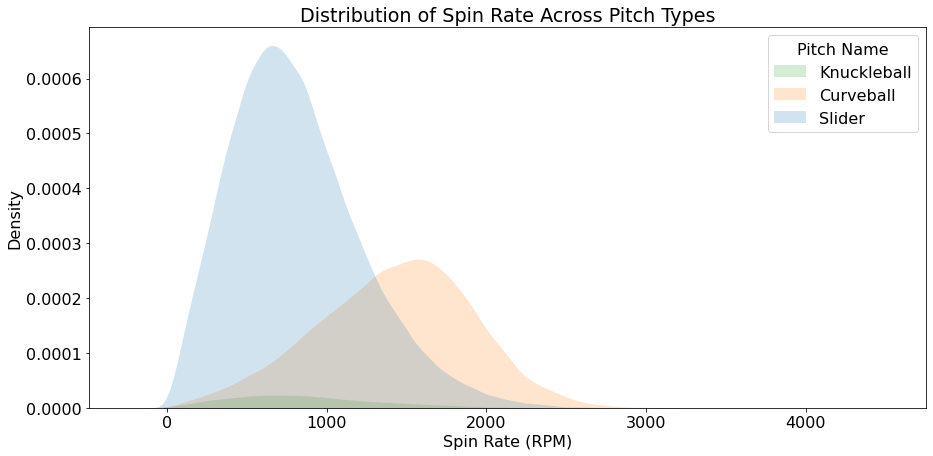

,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,72641.0,1641.0,480.0,28.0,1332.0,1656.0,1963.0,4156.0
CU,56379.0,1420.0,489.0,18.0,1091.0,1450.0,1762.0,4094.0
FC,41702.0,1237.0,580.0,3.0,807.0,1161.0,1625.0,5229.0
FF,238541.0,2033.0,446.0,15.0,1759.0,2050.0,2327.0,5421.0
FS,10503.0,1296.0,483.0,16.0,951.0,1292.0,1630.0,3145.0
FT,81056.0,2184.0,428.0,34.0,1908.0,2173.0,2451.0,5022.0
KN,4450.0,866.0,464.0,9.0,520.0,806.0,1144.0,3205.0
SI,87740.0,2072.0,430.0,61.0,1793.0,2056.0,2339.0,4574.0
SL,109756.0,807.0,411.0,1.0,507.0,755.0,1049.0,4394.0


In [28]:
plt.rcParams['figure.figsize'] = [15, 7]
sns.kdeplot(data=pitches.loc[pitches["pitch_type"].isin(["SL","CU","KN"])], 
            x="spin_rate", hue="pitch_type", fill=True, common_norm=True,alpha=.2, linewidth=0)
plt.xlabel("Spin Rate (RPM)")
plt.legend(title='Pitch Name', labels = ["Knuckleball","Curveball","Slider"])
plt.title("Distribution of Spin Rate Across Pitch Types")
plt.show()

round(pitches.loc[pitches["pitch_type"].isin(["FF","SL","SI","FT","CH","CU","FC","FS","KN"])].groupby('pitch_type')['spin_rate'].describe())

$\quad$ Lastly, I spent time manipulating the data by performing feature engineering and re-labeling categorical columns. I have  highlighted the major changes below. 

* Created Pitch Name
    * Re-labeled pitch type abbreviations (FS = Splitter, CU = Curveball, etc)
    * Only kept most common pitch types (4-seam FB, 2-seam FB, cutter, sinker, slider, curveball, splitter, changeup)
* Created Previous Pitch Name
    * For each pitcher, the pitch name of their previous pitch
    * Not available for each pitcher's first pitch of every appearance made
* Created Pitch Category
    * Grouped pitch type into fastball, offspeed, and breaking ball pitches
* Created Previous Pitch Category
    * For each pitcher, the pitch category of their previous pitch
    * Not available for each pitcher's first pitch of every appearance made
* Created Base State
    * Used on_1b, on_2b, on_3B columns to label the 8 base states 
    * Bases Empty, 1st Only, 2nd Only, 3rd Only, 1st and 2nd, 2nd and 3rd, 1st and 3rd, and Bases Loaded
* Created Platoon Indicator Variable
    * Platoons in baseball represent batter-pitcher matchups in which their sides differ
    * Right Handed Pitcher vs Left Handed Batter and Left Handed Pitcher vs Right Handed Batter
    * Platoon matchups are considered an advantage for hitters due to being able to see the ball better after the pitcher releases the ball
    * Pitchers approach lefty hitters different from righty hitters
* Created Run Differential
    * The difference in score (home team runs - away team runs)
* Created In Zone Variable
    * Using the dimensions of the strikezone and given px and pz pitch location coordinates, I defined if each pitcher landed inside or outside the strike zone
* Created Count Variable
    * Combined balls and strikes to form count
* Created Previous Nasty
    * For each pitcher, the nasty score of their previous pitch
    * Not available for each pitcher's first pitch of every appearance made 
* Created Previous Speed
    * For each pitcher, the pitch speed of their previous pitch
    * Not available for each pitcher's first pitch of every appearance made
* Created Previous In Zone
    * For each pitcher, whether their previous pitch landed inside or outside the strike zone
    * Not available for each pitcher's first pitch of every appearance made
* Created Cumulative Average Nasty Pitch Score by Pitch Name
    * For each pitcher's pitch name, I calculated the cumulative or rolling average nasty pitch score
    * Made sure no data leakage occured (using future nasty pitch score to calculate current rolling average nasty score)
    * Not available for each pitcher's first pitch thrown in the season
* Created Cumulative Max Speed
    * For each pitcher, what their current fastest pitch thrown measured in miles per hour
    * Not available for every pitcher's first pitch thrown in the season
* Created Cumulative Max Nasty
    * For each pitcher, what their current maximum nasty pitch score is
    * Not available for every pitcher's first pitch thrown in the season
* Created Previous Break Length
    * For each pitcher, their total break length of their previous pitch
    * Not available for each pitcher's first pitch of every appearance made 
* Created Previous Pitch Break (pfx_x and pfx_z)
    * For each pitcher, their previous pitch movement coordinates
    * Not available for each pitcher's first pitch of every appearance made 
    * Took absolute value of pfx_x horizontal movement coordinate
* Created Previous Pitch Location (px, pz)
    * For each pitcher, their previous pitch location coordinates
    * Not available for each pitcher's first pitch of every appearance made
    * Took absolute value of px horizontal location coordinate
* Previous Whiff
    * For each pitcher, whether or not their previous pitch resulted in a swing and miss
    * Not available for each pitcher's first pitch of every appearance made
    
$\quad$ Ten rows of the data are shown below post data cleaning procedures. 

In [29]:
pitches.sort_values(['game_pk','pitcher_id','pcount_pitcher'], ascending = [True,False,True], inplace = True)
pitches = pitches.assign(previous_pitch_type = pitches.groupby(["game_pk", "pitcher_id"]).pitch_type.shift(1),
                         pitch_name = np.where(pitches['pitch_type'] == 'FF', '4-Seam Fastball',
                                      np.where(pitches['pitch_type'] == 'SL', 'Slider',
                                      np.where(pitches['pitch_type'] == 'SI', 'Sinker',
                                      np.where(pitches['pitch_type'] == 'FT', '2-Seam Fastball',
                                      np.where(pitches['pitch_type'] == 'CH', 'Changeup',
                                      np.where(pitches['pitch_type'] == 'CU', 'Curveball',
                                      np.where(pitches['pitch_type'] == 'FS', 'Splitter',
                                      np.where(pitches['pitch_type'] == 'FC', 'Cutter',
                                      np.where(pitches['pitch_type'] == 'KC', 'Curveball', 'Other'))))))))),
                         pitch_category = np.where(pitches['pitch_type'] == "FF", 'Fastball',
                                          np.where(pitches['pitch_type'] == 'SI', 'Fastball',
                                          np.where(pitches['pitch_type'] == 'FT', 'Fastball',
                                          np.where(pitches['pitch_type'] == 'CH', 'Offspeed',
                                          np.where(pitches['pitch_type'] == 'CU', 'Breaking Ball',
                                          np.where(pitches['pitch_type'] == 'FS', 'Offspeed',
                                          np.where(pitches['pitch_type'] == 'FC', 'Fastball',
                                          np.where(pitches['pitch_type'] == 'KN', 'Breaking Ball',
                                          np.where(pitches['pitch_type'] == 'SL', 'Breaking Ball',
                                          np.where(pitches['pitch_type'] == 'KC', 'Breaking Ball', 'Other')))))))))),
                         base_state = np.where((pitches['on_1b'].isnull()) & (pitches['on_2b'].isnull()) & (pitches['on_3b'].isnull()), "Bases Empty",
                                      np.where((pitches['on_1b'].notnull()) & (pitches['on_2b'].isnull()) & (pitches['on_3b'].isnull()), "1st Only", 
                                      np.where((pitches['on_1b'].isnull()) & (pitches['on_2b'].notnull()) & (pitches['on_3b'].isnull()), "2nd Only",
                                      np.where((pitches['on_1b'].isnull()) & (pitches['on_2b'].isnull()) & (pitches['on_3b'].notnull()), "3rd Only",         
                                      np.where((pitches['on_1b'].notnull()) & (pitches['on_2b'].notnull()) & (pitches['on_3b'].isnull()), "1st & 2nd",        
                                      np.where((pitches['on_1b'].isnull()) & (pitches['on_2b'].notnull()) & (pitches['on_3b'].notnull()), "2nd & 3rd", 
                                      np.where((pitches['on_1b'].notnull()) & (pitches['on_2b'].isnull()) & (pitches['on_3b'].notnull()), "1st & 3rd", "Bases Loaded"))))))),
                         platoon = np.where((pitches['p_throws'] == "R") & (pitches['stand'] == "L"), "Is_Platoon",
                                   np.where((pitches['p_throws'] == "L") & (pitches['stand'] == "R"), "Is_Platoon","Not_Platoon")),
                         balls = np.where(pitches["balls"] > 3, 3, pitches["balls"]),
                         p_throws = np.where(pitches['p_throws'] == "L", "LHP", "RHP"),
                         stand = np.where(pitches['stand'] == "L", "LHB", "RHB"),
                         topinning = np.where(pitches['top'] == 1, "Top", "Bot"),
                         whiff = np.where(pitches['pitch_des'] == "Swinging Strike", "Whiff", 
                                 np.where(pitches['pitch_des'] == "Swinging Strike (Blocked)","Whiff","No Whiff")),
                         px = -pitches['px'],
                         px_abs = np.abs(-pitches['px']),
                         pfx_x = -pitches['pfx_x'],
                         pfx_x_abs = np.abs(-pitches['pfx_x']),
                         run_diff = np.abs(pitches["home_team_runs"] - pitches["away_team_runs"]),
                         in_zone = np.where((pitches['pz'] <= 3.45) & (pitches['pz'] >= 1.55) & (np.abs(pitches['px']) <= 0.95), "Inside Zone", "Outside Zone")
                         )

pitches["Inning"] = pitches["topinning"] + " " + pitches["inning"].astype(str)

pitches["count"] = pitches['balls'].astype(str) + '-' + pitches['strikes'].astype(str)

pitches["previous_pitch_name"] = np.where(pitches['previous_pitch_type'] == 'FF', 'Previous 4-Seam Fastball',
                                 np.where(pitches['previous_pitch_type'] == 'SL', 'Previous Slider',
                                 np.where(pitches['previous_pitch_type'] == 'SI', 'Previous Sinker',
                                 np.where(pitches['previous_pitch_type'] == 'FT', 'Previous 2-Seam Fastball',
                                 np.where(pitches['previous_pitch_type'] == 'CH', 'Previous Changeup',
                                 np.where(pitches['previous_pitch_type'] == 'CU', 'Previous Curveball',
                                 np.where(pitches['previous_pitch_type'] == 'FC', 'Previous Cutter',
                                 np.where(pitches['previous_pitch_type'] == 'FS', 'Previous Splitter',
                                 np.where(pitches['previous_pitch_type'] == 'KC', 'Previous Curveball','Previous Other')))))))))

pitches["previous_pitch_category"] = np.where(pitches['previous_pitch_type'] == "FF", 'Previous Fastball',
                                     np.where(pitches['previous_pitch_type'] == 'SI', 'Previous Fastball',
                                     np.where(pitches['previous_pitch_type'] == 'FT', 'Previous Fastball',
                                     np.where(pitches['previous_pitch_type'] == 'CH', 'Previous Offspeed',
                                     np.where(pitches['previous_pitch_type'] == 'CU', 'Previous Breaking Ball',
                                     np.where(pitches['previous_pitch_type'] == 'FS', 'Previous Offspeed',
                                     np.where(pitches['previous_pitch_type'] == 'FC', 'Previous Fastball',
                                     np.where(pitches['previous_pitch_type'] == 'SL', 'Previous Breaking Ball',
                                     np.where(pitches['previous_pitch_type'] == 'KN', 'Previous Breaking Ball',
                                     np.where(pitches['previous_pitch_type'] == 'KC', 'Previous Breaking Ball', 'Previous Other'))))))))))

pitches.sort_values(['game_pk','pitcher_id','pcount_pitcher'], ascending = [True,False,True], inplace = True)
pitches = pitches.assign(previous_nasty = pitches.groupby(["pitcher_id","game_pk"]).nasty.shift(1),
                         previous_whiff = pitches.groupby(["pitcher_id","game_pk"]).whiff.shift(1),
                         previous_speed = pitches.groupby(["pitcher_id","game_pk"]).start_speed.shift(1),
                         previous_in_zone = pitches.groupby(["pitcher_id","game_pk"]).in_zone.shift(1),
                         previous_px_abs = pitches.groupby(["pitcher_id","game_pk"]).px_abs.shift(1),
                         previous_pz = pitches.groupby(["pitcher_id","game_pk"]).pz.shift(1),
                         previous_pfx_x_abs = pitches.groupby(["pitcher_id","game_pk"]).pfx_x_abs.shift(1),
                         previous_pfx_z = pitches.groupby(["pitcher_id","game_pk"]).pfx_z.shift(1),
                         previous_break_length = pitches.groupby(["pitcher_id","game_pk"]).break_length.shift(1))

pitches["previous_in_zone"] = np.where(pitches["previous_in_zone"] == "Inside Zone","Previous Inside Zone","Previous Outside Zone")


pitches.sort_values(['pitcher_id','game_pk','pcount_pitcher'], ascending = [False,True,True], inplace = True)
pitches = pitches.assign(cumulative_avg_nasty_by_pitch_name = pitches.groupby(['pitcher_id','pitch_name'])['nasty'].apply(lambda x: x.shift().expanding().mean()),
                         cumulative_max_speed = pitches.groupby(['pitcher_id'])['start_speed'].apply(lambda x: x.shift().expanding().max()),
                         cumulative_max_nasty = pitches.groupby(['pitcher_id'])['nasty'].apply(lambda x: x.shift().expanding().max()))                                             

pitches = pitches[pitches["pitch_name"] != "Other"]   
pitches.drop(['on_3b', 'on_2b','on_1b','score'], axis=1, inplace = True)

In [64]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(pitches.tail(10).sort_values(['at_bat_num','pcount_at_bat']))

,uid,game_pk,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,away_team_runs,home_team_runs,pitch_des,pitch_id,type,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,previous_pitch_type,pitch_name,pitch_category,base_state,platoon,topinning,whiff,px_abs,pfx_x_abs,run_diff,in_zone,Inning,count,previous_pitch_name,previous_pitch_category,previous_nasty,previous_whiff,previous_speed,previous_in_zone,previous_px_abs,previous_pz,previous_pfx_x_abs,previous_pfx_z,previous_break_length,cumulative_avg_nasty_by_pitch_name,cumulative_max_speed,cumulative_max_nasty
704294,19756476,289312,2011-09-28,113,121,9,1,60,5,114,2,2,1,0,0,2,2,1,121074,RHB,6-1,110683,RHP,"Edgar Renteria grounds out, shortstop Ruben Te...",Groundout,0,3,Foul,460,S,91.8,85.4,3.44,1.59,-1.63,5.67,-0.797,3.193,4.9,23.9,-9.6,FF,2.000,12.0,59.0,164.101,1186.265,FF,4-Seam Fastball,Fastball,Bases Empty,Not_Platoon,Top,No Whiff,0.797,1.63,3,Inside Zone,Top 9,2-2,Previous 4-Seam Fastball,Previous Fastball,34.0,No Whiff,92.0,Previous Outside Zone,2.439,1.660,0.54,6.82,4.7,47.286957,95.7,93.0
704295,19756477,289312,2011-09-28,113,121,9,1,60,6,115,2,2,2,0,0,2,2,1,121074,RHB,6-1,110683,RHP,"Edgar Renteria grounds out, shortstop Ruben Te...",Groundout,0,3,Foul,461,S,91.9,85.9,3.44,1.59,1.17,7.43,-0.092,3.656,4.1,23.9,4.8,FF,2.000,12.0,42.0,188.887,1521.859,FF,4-Seam Fastball,Fastball,Bases Empty,Not_Platoon,Top,No Whiff,0.092,1.17,3,Outside Zone,Top 9,2-2,Previous 4-Seam Fastball,Previous Fastball,59.0,No Whiff,91.8,Previous Inside Zone,0.797,3.193,1.63,5.67,4.9,47.337662,95.7,93.0
704296,19756478,289312,2011-09-28,113,121,9,1,60,7,116,2,2,3,0,1,2,2,1,121074,RHB,6-1,110683,RHP,"Edgar Renteria grounds out, shortstop Ruben Te...",Groundout,0,3,"In play, out(s)",462,X,84.9,80.2,3.44,1.59,-3.62,-0.79,1.149,2.667,8.6,23.9,-10.0,SL,2.000,11.0,43.0,78.363,691.840,FF,Slider,Breaking Ball,Bases Empty,Not_Platoon,Top,No Whiff,1.149,3.62,3,Outside Zone,Top 9,2-2,Previous 4-Seam Fastball,Previous Fastball,42.0,No Whiff,91.9,Previous Outside Zone,0.092,3.656,1.17,7.43,4.1,43.858369,95.7,93.0
704297,19756479,289312,2011-09-28,113,121,9,1,61,1,117,0,0,0,1,0,1,2,2,458015,LHB,6-2,110683,RHP,"Joey Votto grounds out, first baseman Nick Eva...",Groundout,0,3,Called Strike,466,S,85.5,80.0,3.54,1.58,-4.35,0.90,0.585,2.158,8.0,23.9,-12.9,SL,2.000,7.0,71.0,102.301,830.834,SL,Slider,Breaking Ball,Bases Empty,Is_Platoon,Top,No Whiff,0.585,4.35,3,Inside Zone,Top 9,0-0,Previous Slider,Previous Breaking Ball,43.0,No Whiff,84.9,Previous Outside Zone,1.149,2.667,3.62,-0.79,8.6,43.854701,95.7,93.0
704298,19756480,289312,2011-09-28,113,121,9,1,61,2,118,0,1,0,1,0,1,2,2,458015,LHB,6-2,110683,RHP,"Joey Votto grounds out, first baseman Nick Eva...",Groundout,0,3,Foul,467,S,85.4,80.2,3.17,1.47,-3.72,3.32,0.418,2.939,6.9,23.9,-12.8,SL,2.000,1.0,39.0,132.090,940.183,SL,Slider,Breaking Ball,Bases Empty,Is_Platoon,Top,No Whiff,0.418,3.72,3,Inside Zone,Top 9,0-1,Previous Slider,Previous Breaking Ball,71.0,No Whiff,85.5,Previous Inside Zone,0.585,2.158,4.35,0.90,8.0,43.970213,95.7,93.0
704299,19756481,289312,2011-09-28,113,121,9,1,61,3,119,0,2,1,1,0,1,2,2,458015,LHB,6-2,110683,RHP,"Joey Votto grounds out, first baseman Nick Eva...",Groundout,0,3,Ball,468,B,85.7,81.1,3.49,1.50,-3.56,3.80,-0.107,0.194,6.9,24.0,-12.6,SL,0.896,14.0,16.0,137.166,985.459,SL,Slider,Breaking Ball,Bases Empty,Is_Platoon,Top,No Whiff,0.107,3.56,3,Outside Zone,Top 9,0-2,Previous Slider,Previous Breaking Ball,39.0,No Whiff,85.4,Previous Inside Zone,0.418,2.939,3.72,3.32,6.9,43.949153,95.7,93.0
704300,19756482,289312,2011-09-28,113,121,9,1,61,4,120,1,2,1,1,1,1,2,2,458015,LHB,6-2,110683,RHP,"Joey Votto grounds out, first baseman Nick Eva...",Groundout,0,3,"In play, out(s)",469,X,86.6,81.1,3.17,1.47

$\quad$ After the data cleaning process, I was left with these variables that have missing values. Since they represent such as small portion of the entire data set (< 3%). I decided it is appropriate to simply drop missing rows from the data set during the modeling stage as removing them would not have a significant effect during the model training phase. 

In [31]:
# Check percentage of missing data per column in la table
missing = missing_values_table(pitches)
display(HTML(missing.to_html()))

Your selected dataframe has 74 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
previous_pitch_type,19931,2.8
previous_nasty,19931,2.8
previous_speed,19931,2.8
previous_px_abs,19931,2.8
previous_pz,19931,2.8
previous_pfx_x_abs,19931,2.8
previous_pfx_z,19931,2.8
previous_break_length,19931,2.8
previous_whiff,18921,2.7
cumulative_avg_nasty_by_pitch_name,2982,0.4


## Data Visualizations

$\quad$ To understand the proportion of pitch types after the data cleaning process, I created the horizontal bar chart below displaying the counts and percentages. The most common pitch type in baseball is the straight 4-seam fastball which occurs around one-third of the time. 2-Seam fastballs, sinkers, and cutters are also part of the fastball family but differ slightly in movement at the end. 2-Seamers or sinkers have more arm-side tail (horizontal movement throwing hand side) and more sink (vertical movement down) than 4-seamers while cutters have more glove side horizontal movement similar to a hard slider. Sliders are the most common breaking ball pitch at 15.5%. One of the hardest pitches to throw in baseball is the splitter because it is difficult to grip and throw the pitch with good control/command which is why it is only thrown at 1.5% of all pitches. Pitchers can develop blisters if splitters are thrown too often as well.    

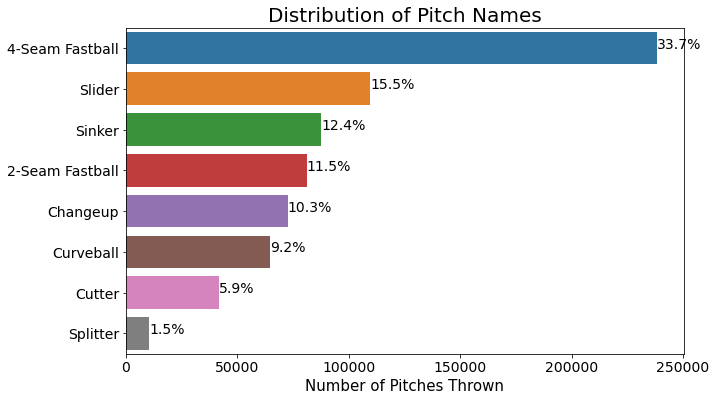

In [70]:
plt.figure(figsize=(10,6))
ax = sns.countplot(y="pitch_name", data=pitches, order = pitches['pitch_name'].value_counts().index)
plt.xlabel('Number of Pitches Thrown', fontsize = 15)
plt.title('Distribution of Pitch Names', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("")

total = len(pitches['pitch_name'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=14)

plt.show()

$\quad$ I was curious to see the breakdown by similar pitch categories. I grouped 4-seam, 2-seam, cutters, and sinkers together to form fastballs while breaking balls are curveballs, sliders, knucklecurves, and knuckleballs. The remaining pitches (change-ups and splitters) are offspeed pitches because they tunnel well off the fastball at a slower speed. If we limit the pitch types to just these three groups, then a batter on average has about a 63% chance of predicting some type of fastball is coming on the next pitch. Now our model is more complicated since I am keeping each pitch type separate but I would expect a model to be able to predict at least 60% of all pitches correctly.  

In [13]:
counts = pitches["pitch_category"].value_counts()
percents = pitches["pitch_category"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts': counts, 'percents':percents}))

,Fastball,Breaking Ball,Offspeed
counts,449039,174625,83144
percents,63.5%,24.7%,11.8%


$\quad$ Before any modeling, it is important to get a better understanding of the data by visualizing potential predictor variables against the response variable. Generally, we know game situation such as count plays a huge role in determining what pitch type is most likely to be thrown. The following color-coded 100% horizontal stacked bar chart shows how the percentage of pitch type changes significantly as count changes. We see that when a pitcher falls behind (3-0, 3-1, 3-2), they thrown a higher percentage of 4-seam fastballs since this pitch type is known to be the easiest in locating the strikezone. When pitchers are ahead in the count (0-2, 1-2, 2-2), they incorporate more breaking balls most likely out of the zone to fool hitters into chasing. We can easily see how the distribution of 4-seam fastballs (orange bar), curveballs (red bar), and sliders (pink bar) change in different counts. 

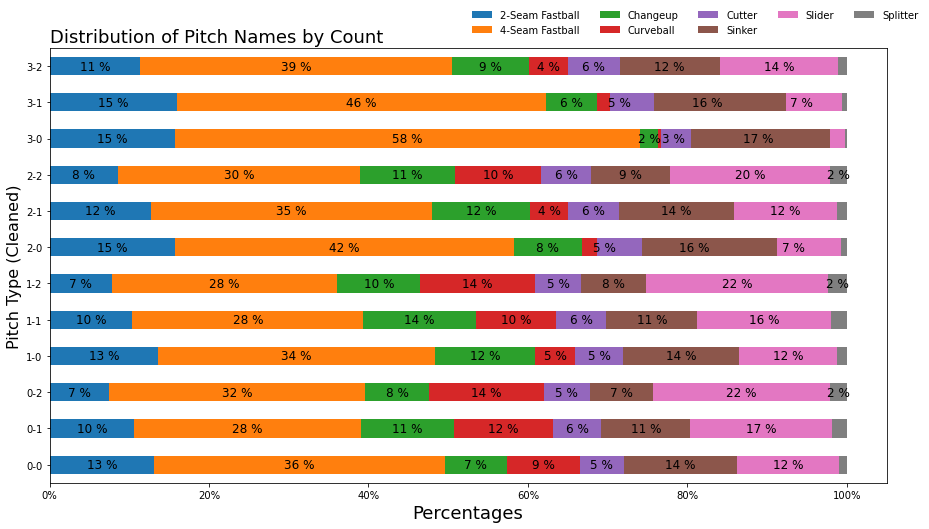

In [69]:
warnings.filterwarnings('ignore') 
horz_stacked_bar_chart_perc(pitches, "count", "pitch_name", "Pitch Type (Cleaned)" ,
                            "Distribution of Pitch Names by Count")

$\quad$ Next, I decided to take a look at how previous pitch type influences the upcoming pitch type. For this, I created a two-way table where the rows represent the previous pitch type and the columns show the current or next upcoming pitch type. The values tell us for each previous pitch type, the proportion or distribution of the following pitch type. For example, we see that if a cutter is thrown, then there is over a 50% chance that the next pitch will also be a cutter. Interestingly, a sinker/4-seam fastball sequence seems to happen rarely. Observing common or uncommom pitch type combinations can tell us a bit about pitch mixes. Pitchers who rely on sinkers/2-seamers often pitch to contact and don't have nasty high-velocity 4-seamers which is why sinker/4-seam or 2-seam/4-seam combinations don't happen often. Typically, fastball types (4-seam, 2-seam, cutter, sinker) are most commonly followed up with the same pitch. For splitters and change-ups, the 4-seam fastball is the most common next pitch which makes sense as they compliment each other very well. Lastly, both curveballs and sliders also are followed up most often with 4-seam fastballs.  

In [38]:
pitches2 = pitches.loc[pitches['previous_pitch_name'] != "Previous Other"]
tab = pd.crosstab(pitches2.previous_pitch_name, pitches2.pitch_name, normalize='index')
tab.style.background_gradient(axis=None, cmap='YlOrRd').set_precision(3)

pitch_name,2-Seam Fastball,4-Seam Fastball,Changeup,Curveball,Cutter,Sinker,Slider,Splitter
previous_pitch_name,,,,,,,,
Previous 2-Seam Fastball,0.379,0.236,0.112,0.095,0.036,0.001,0.130,0.010
Previous 4-Seam Fastball,0.083,0.485,0.094,0.088,0.043,0.036,0.158,0.013
Previous Changeup,0.120,0.307,0.218,0.081,0.055,0.118,0.100,0.001
Previous Curveball,0.114,0.306,0.106,0.212,0.073,0.095,0.082,0.012
Previous Cutter,0.070,0.239,0.095,0.118,0.333,0.076,0.059,0.009
Previous Sinker,0.001,0.093,0.103,0.074,0.037,0.531,0.141,0.020
Previous Slider,0.095,0.339,0.063,0.049,0.022,0.112,0.310,0.009
Previous Splitter,0.073,0.303,0.009,0.063,0.040,0.162,0.094,0.257


$\quad$ I include the same two-way table for pitch category below. A a hitter, this would tell me when in doubt, guess fastball. No pitcher throws every type of fastball and a hitter would know in advance if the pitcher has 1, 2, or 3 fastball types in their repetoire. In general with no other information, hitters should expect the fastball but we aware a 2nd breaking ball could be coming if the previous pitch was a breaking ball. 

In [39]:
pitches2 = pitches.loc[pitches['previous_pitch_category'] != "Previous Other"]
tab = pd.crosstab(pitches2.previous_pitch_category, pitches2.pitch_category, normalize='index')
tab.style.background_gradient(axis=None, cmap='YlOrRd').set_precision(3)

pitch_category,Breaking Ball,Fastball,Offspeed
previous_pitch_category,,,
Previous Breaking Ball,0.334,0.577,0.089
Previous Fastball,0.230,0.658,0.112
Previous Offspeed,0.178,0.597,0.225


## Feature Selection

$\quad$ I used intuition and practicality to select my feature set to use as model inputs. I incorporated game information such as count, number of outs, current number of fouls in at bat, inning, run differential, base state, current pitch count, current at bat pitch count. Next, I included pitcher specific variables such as current max speed, current average nasty score by pitch type, previous pitch speed, previous pitch type, previous break length, current max nasty score, previous pitch category, pitcher throw side, previous in zone, is platoon, previous pitch location (px and pz), previous pitch movement (pfx_x and pfx_z). 

In [43]:
numeric_inputs = ['inning','fouls','outs','run_diff','pcount_pitcher',"pcount_at_bat","cumulative_max_speed",
                  "cumulative_avg_nasty_by_pitch_name","previous_speed","previous_nasty","pitcher_id",
                  "previous_px_abs", "previous_pz","previous_break_length","previous_pfx_x_abs","previous_pfx_z",
                  "cumulative_max_nasty"]

category_inputs = ["count","previous_pitch_name",'previous_pitch_category',"base_state","platoon","p_throws",
                   "previous_in_zone","previous_whiff"]

## Machine Learning Approach

$\quad$ My approach was to train several machine learning multi-classification algorithms on a training data set and predict pitch name on unseen, testing data. Then, I compare each algorithm’s performance based on multiple criteria: overall accuracy, overall precision, overall recall, overall F1 score, class precision, class recall, and class F1 score. Our original data set has over 700,000 pitches after removing about 2,000 rows of data with missing inputs which is much more than needed for models to train and learn. Therefore, I took a random sample of 200,000 rows from the training data. 80% of this sample data (160,000 rows) was used for training while 20% of the data was used as the testing set (40,000 rows) to evaluate the model. I chose the model that performed best across the performance metrics on the testing set as my final model. I chose to compare four algorithms (k-th nearest neighbors, random forest, gradient boosting machine, and xg boost) using 5-fold cross validation each time on the training set. I created dummy indicator variables for all categorical/factor features. For hyper-parameter tuning, I specified an iteration of different default values for each model. Below are the test performance metrics, confusion matrix (normalized and raw counts) of test predictions, and variable importance chart for the best performing model, extreme gradient boosting model (XGBoost).

### Model Validation

y_train dim:  (160000,)
X_train dim:  (160000, 58)
X_test dim:  (40000, 58)
y_test dim: (40000,)
Total Rows:  200000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Test Accuracy: 0.759800
Test Precision: 0.759000
Test Recall: 0.759800
Test F1 score: 0.754500
              precision    recall  f1-score   support

      2-Seam       0.80      0.80      0.80      4584
      4-Seam       0.76      0.90      0.82     13514
    Changeup       0.68      0.62      0.64      4093
   Curveball       0.75      0.63      0.68      3722
      Cutter       0.74      0.47      0.58      2352
      Sinker       0.84      0.81      0.83      4977
      Slider       0.71      0.69      0.70      6174
    Splitter       0.84      0.52      0.64       584

    accuracy                           0.76     40000
   macro avg       0.77      0.68      0.71     40000
weighted avg       0.76      0.76      0.75     40000



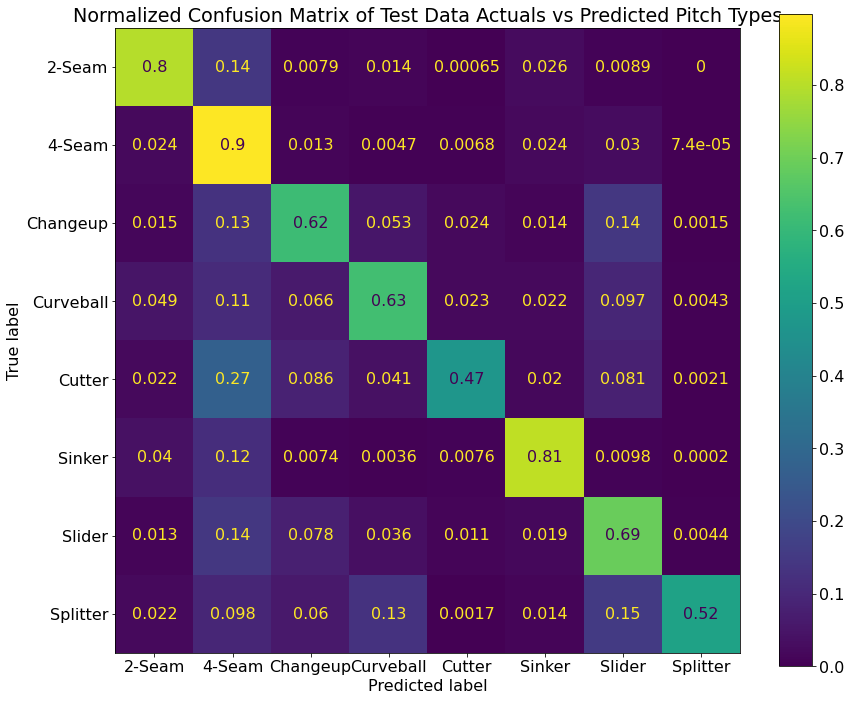

In [44]:
# XGB, Best Model
#RandomForestClassifier, GBM, XGB, KNN
warnings.filterwarnings('ignore') 
model_country_xgb = model_pitch_type(pitches, numeric_inputs, category_inputs, "XGB", 
                                     metric = "f1_macro", sample = 200000)

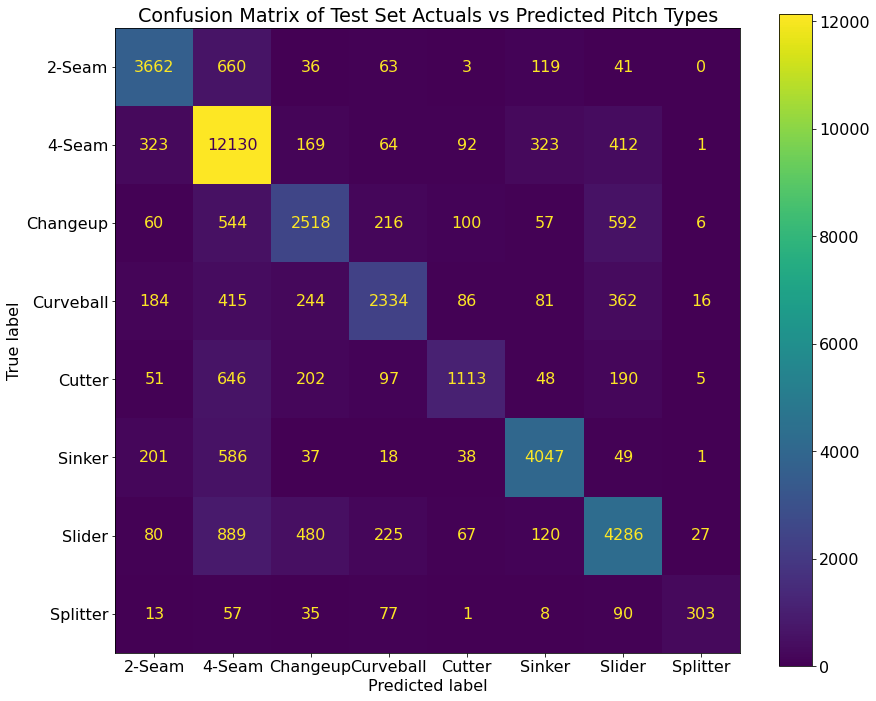

In [45]:
plt.rcParams['figure.figsize'] = [14, 12]
model_country_xgb[2].plot()
plt.title("Confusion Matrix of Test Set Actuals vs Predicted Pitch Types")
plt.show()

$\quad$ As expected, we see that the 4-seam fastball (most common pitch) had the best prediction performance among all pitch types. Especially for pitchers with elite fastballs such as Carlos Rodon or Jacob DeGrom, batters come up to the plate expecting the high heater on almost every pitch. Interestingly, the worst performing pitch type according to F1-Score is the cutter which only is thrown less than 6% of the time. The confusion matrix below helps to show which pitches are being identified correctly most often as well as if any pitch type is being under-predicted or over-predicted. We see that the cutter has a signficant percentage of miss-classified predictions and a large portion of pitches were predicted as 4-seam fastballs. Cutters were also being classifed as change-ups and sliders. For splitters, we see that the model predicted many cases that the pitch would be a curveball or slider. In many cases, the splitter can also act as a put-away breaking ball for pitchers such as Kevin Gausman who gets lots of strikeouts with the splitter where other pitchers may use curveballs or sliders in those situations.  

### Variable Importance

$\quad$ Viewing the variable importance chart below, the most important variables in predicting the next pitch type is the previous pitch type with an emphasis on fastballs (sinker, 2-seam, cutter, 4-seam) as well as sliders, splitters, and curveballs. Interestingly, the 5th most important variable is a pitcher's rolling average nasty pitch score by pitch type and the 3-0 count proved to be the most important count to predict pitch type. My intuition of platoon matchups changing how pitcher's approach batters seems to have some validity as it has a positive feature important scale value. 

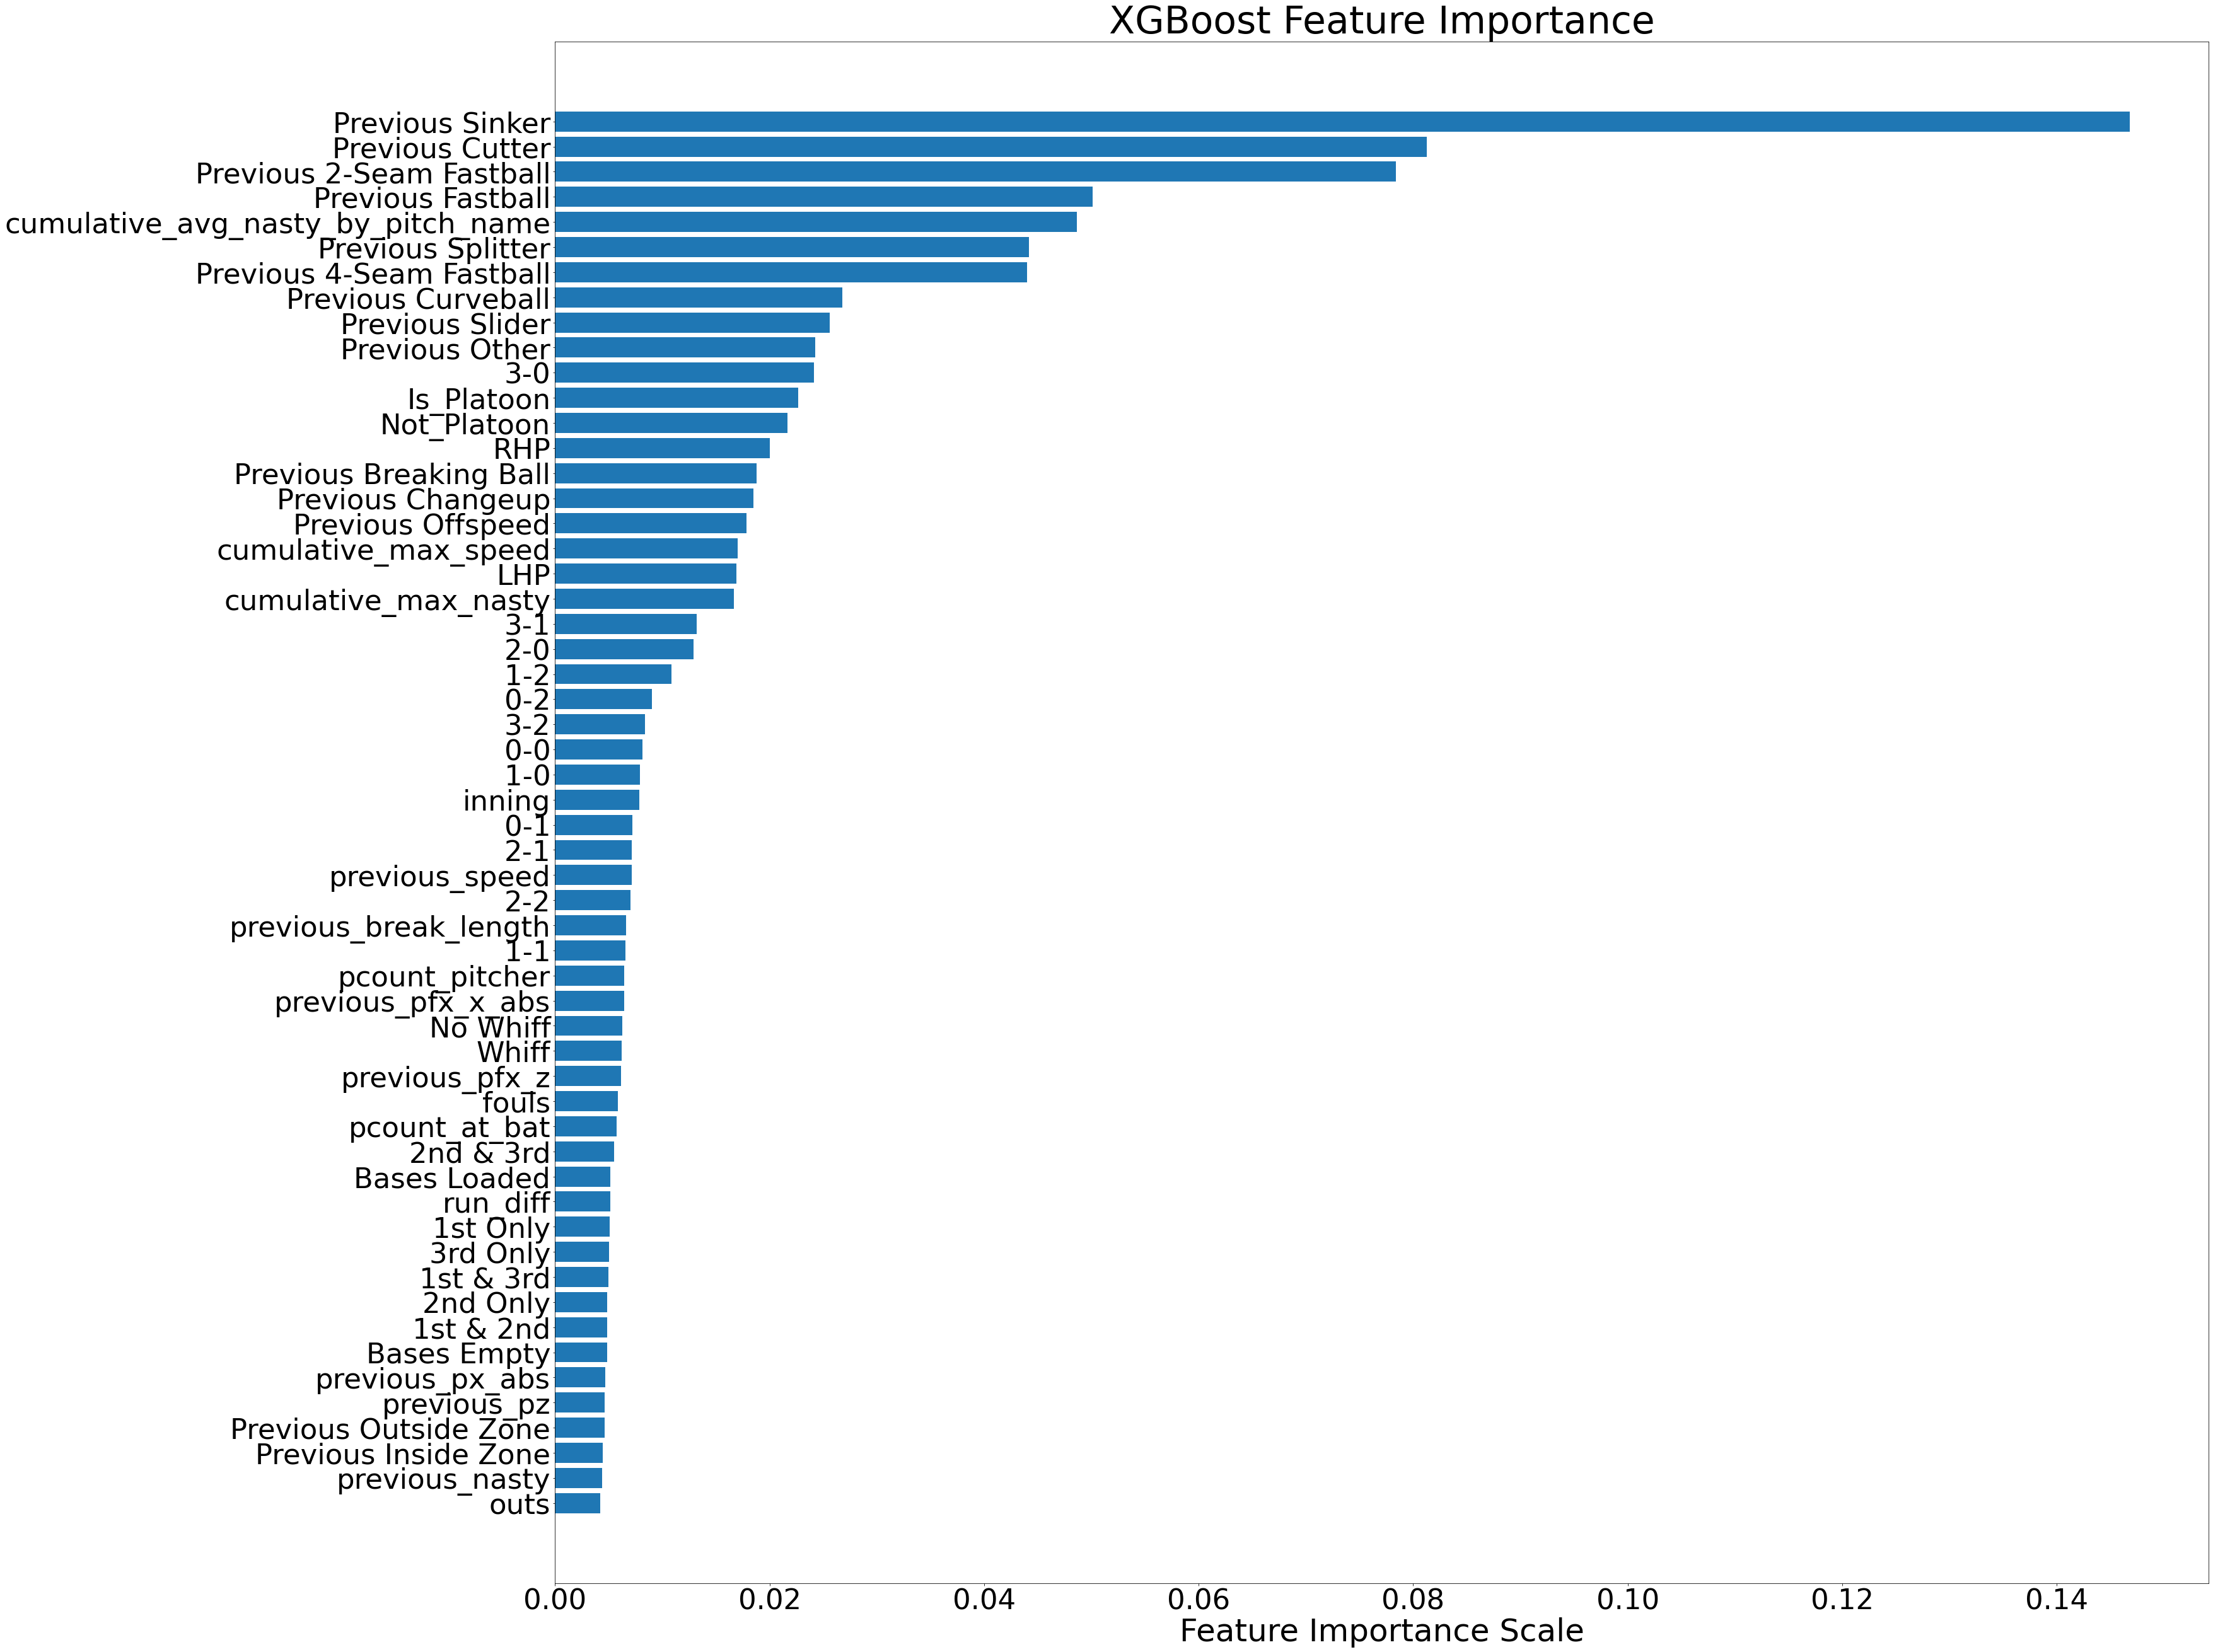

In [54]:
model_type = 'XGBoost'
plt.rcParams['figure.figsize'] = [47, 45]
var_imp = model_country_xgb[0].best_estimator_.named_steps["classifier"].feature_importances_
imp = pd.DataFrame({'features': model_country_xgb[3], 'importance': var_imp}).sort_values('importance', ascending = True)
plt.barh(imp.features, imp.importance)
plt.tick_params(axis='both', which='major', labelsize=45)
plt.title("{} Feature Importance".format(model_type), fontsize = 60)
plt.xlabel("Feature Importance Scale", fontsize = 50)
plt.show()

### Visualizing Test Predictions

$\quad$ The plot below represents the kernel density estimate of the distribution of predicted probabilities for each predicted pitch type from the testing set. To be clear, each pitch has 8 probabilities associated with each possible pitch type. Therefore, I am plotting the probability associated with the most likely pitch class (max probability prediction per pitch). For fastballs, we see it's distribution left skewed such that most of the area under the curve falls within 0.6 and 1. This means most of our 4-seam fastball predictions have a high level of confidence that the actual pitch type is indeed a 4-seam fastball. For all other pitch types, their distributions overlap each other with predictions ranging from low confidence (0.2) to high confidence (1).

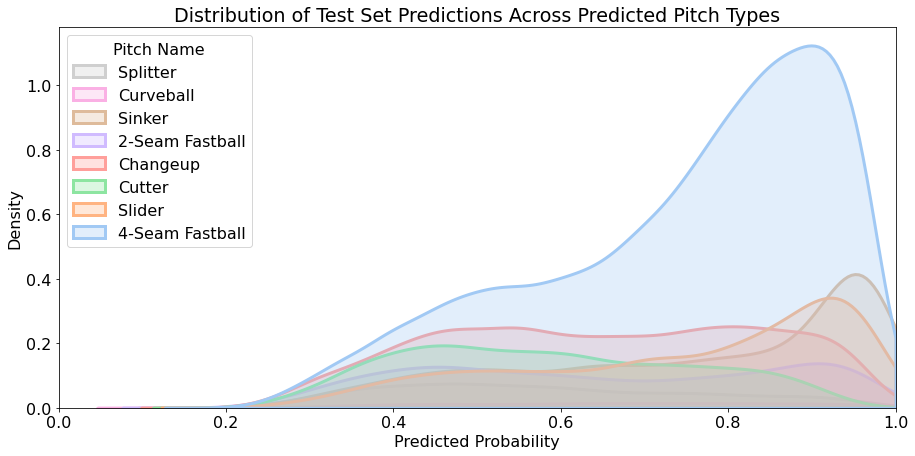

In [67]:
plt.rcParams['figure.figsize'] = [15, 7]
plt.xlim(0, 1)
sns.kdeplot(data=model_country_xgb[1], x="pitch_name_prob", hue="pitch_name_pred", 
            fill=True, common_norm=True,alpha=.3, linewidth=3, clip=(0.0, 1.0), palette="pastel")
plt.xlabel("Predicted Probability")
plt.legend(loc='upper left', title='Pitch Name', labels = ['Splitter','Curveball','Sinker','2-Seam Fastball','Changeup',
                                                          'Cutter','Slider','4-Seam Fastball'])
plt.title("Distribution of Test Set Predictions Across Predicted Pitch Types")
plt.show()

$\quad$ I also include a table below the plot that shows the count of how many times each pitch type was predicted along with the percentage for sanity check. It seems to follow closely with the distribution of actual pitch types with 4-seam fastballs being slightly over-predicted. 

In [71]:
counts = model_country_xgb[1]["pitch_name_pred"].value_counts()
percents = model_country_xgb[1]["pitch_name_pred"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts (predicted)': counts, 'percents (predicted)':percents}))

,4-Seam Fastball,Slider,Sinker,2-Seam Fastball,Changeup,Curveball,Cutter,Splitter
counts (predicted),15927,6022,4803,4574,3721,3094,1500,359
percents (predicted),39.8%,15.1%,12.0%,11.4%,9.3%,7.7%,3.8%,0.9%


In [57]:
counts = model_country_xgb[1]["pitch_name"].value_counts()
percents = model_country_xgb[1]["pitch_name"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts (actual)': counts, 'percents (actual)':percents}))

,4-Seam Fastball,Slider,Sinker,2-Seam Fastball,Changeup,Curveball,Cutter,Splitter
counts (actual),13514,6174,4977,4584,4093,3722,2352,584
percents (actual),33.8%,15.4%,12.4%,11.5%,10.2%,9.3%,5.9%,1.5%


### Full Data Set Predictions

$\quad$ Now that we have chosen and validated the final model to ensure no over-fitting, I used it to make predictions on all pitches from the 2011 season. The performance metrics, confusion matrices, and pitch type prediction distributions on the entire set is very similar to the performance on the testing set. I print and plot them again for the full data set below to verify that our validated model is making similar predictions on the full data set. Due to redundancy, I will refrain from explaining the output below as they are similar to the test set. But, I include them below for any reader interested in examining the full data results.  

Test Accuracy: 0.799100
Test Precision: 0.800000
Test Recall: 0.799100
Test F1 score: 0.795300
              precision    recall  f1-score   support

      2-Seam       0.84      0.83      0.84     78293
      4-Seam       0.79      0.92      0.85    228905
    Changeup       0.74      0.68      0.71     71516
   Curveball       0.80      0.67      0.73     63685
      Cutter       0.79      0.55      0.65     40603
      Sinker       0.87      0.85      0.86     84409
      Slider       0.77      0.75      0.76    106922
    Splitter       0.91      0.62      0.74     10297

    accuracy                           0.80    684630
   macro avg       0.81      0.73      0.77    684630
weighted avg       0.80      0.80      0.80    684630



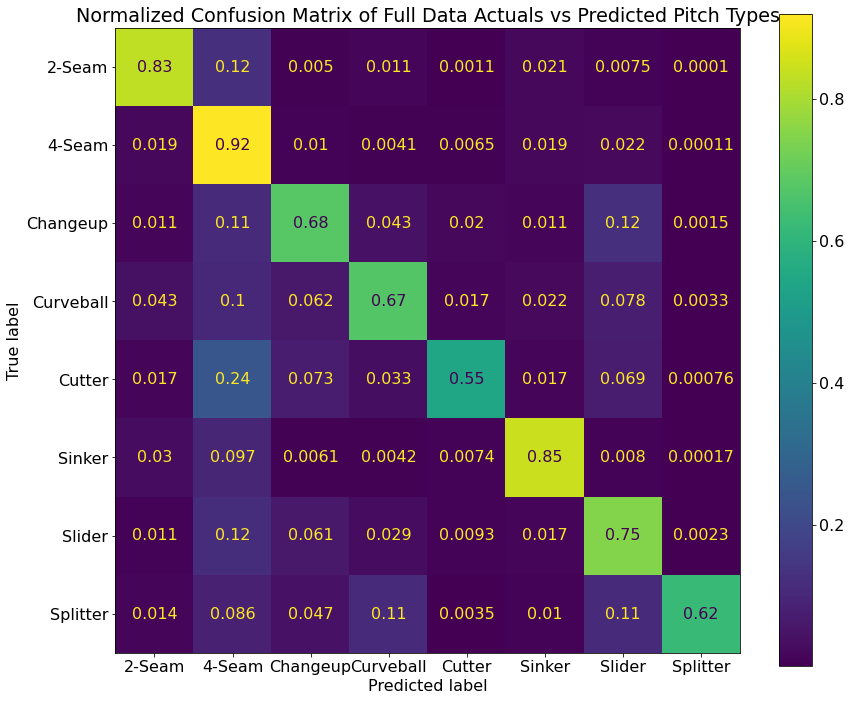

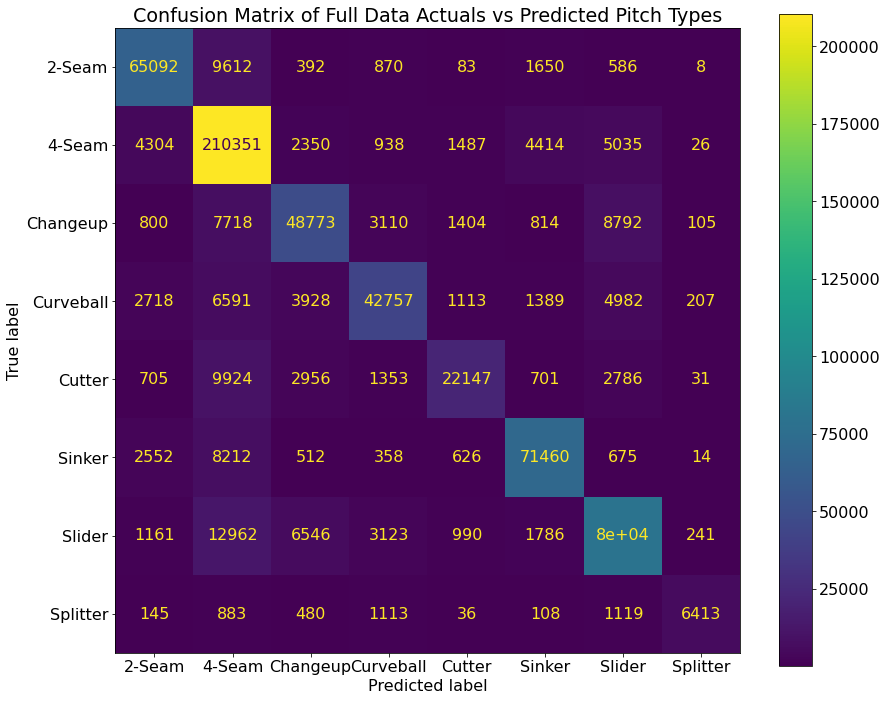

In [58]:
df = pitches[[y for x in [numeric_inputs, category_inputs, ["pitch_name"]] for y in x]]
df = df.dropna()
actual_name = df["pitch_name"]
df.drop(['pitcher_id', 'pitch_name'], axis=1, inplace=True)

le = LabelEncoder()
actuals = le.fit_transform(actual_name)

for column in category_inputs:
        dummies = pd.get_dummies(df[column])
        df[dummies.columns] = dummies
        df = df.drop(labels = column, axis = 1)
        
df_raw = model_country_xgb[0].predict(df)
df_prob = model_country_xgb[0].predict_proba(df)
full_df = pd.DataFrame({"pitch_name": actual_name, "pitch_name_pred": df_raw, "pitch_name_prob": df_prob.max(axis=1, keepdims=False)})
final_df = pd.concat([df.reset_index(), full_df.reset_index()], axis = 1)
final_df.drop('index', axis=1, inplace=True)
final_df["pitch_name_pred"] = np.where(final_df['pitch_name_pred'] == 0, '2-Seam Fastball',
                              np.where(final_df['pitch_name_pred'] == 1, '4-Seam Fastball',
                              np.where(final_df['pitch_name_pred'] == 2, 'Changeup',
                              np.where(final_df['pitch_name_pred'] == 3, 'Curveball',
                              np.where(final_df['pitch_name_pred'] == 4, 'Cutter',
                              np.where(final_df['pitch_name_pred'] == 5, 'Sinker',
                              np.where(final_df['pitch_name_pred'] == 6, 'Slider','Splitter')))))))

values = [0,1,2,3,4,5,6,7]
labels = ['2-Seam','4-Seam','Changeup','Curveball','Cutter','Sinker','Slider','Splitter']
cm = confusion_matrix(actuals, df_raw, labels=model_country_xgb[0].classes_)
confusion = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels) #'true','pred','all'
plt.rcParams['figure.figsize'] = [14, 12]
confusion_norm = ConfusionMatrixDisplay.from_predictions(actuals, df_raw, normalize = 'true', display_labels=labels)
plt.title("Normalized Confusion Matrix of Full Data Actuals vs Predicted Pitch Types")

acc = round(accuracy_score(actuals, df_raw),4)
print('Test Accuracy: %4f' % acc)
precision = round(precision_score(actuals, df_raw, average = 'weighted'),3)
print('Test Precision: %4f' % precision)
recall = round(recall_score(actuals, df_raw, average = 'weighted'),4)
print('Test Recall: %4f' % recall)
f1 = round(f1_score(actuals, df_raw, average = 'weighted'),4)
print('Test F1 score: %4f' % f1)
print(classification_report(actuals, df_raw, target_names = labels))

plt.rcParams['figure.figsize'] = [14, 12]
confusion.plot()
plt.title("Confusion Matrix of Full Data Actuals vs Predicted Pitch Types")
plt.show()

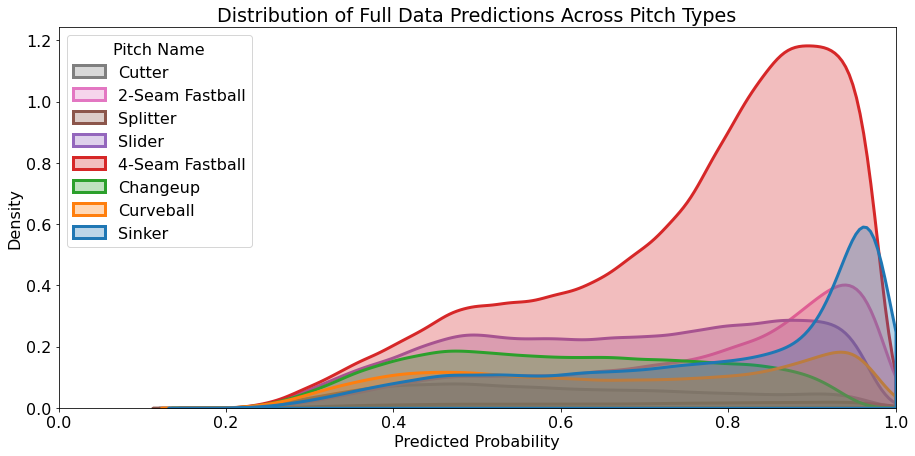

In [66]:
plt.rcParams['figure.figsize'] = [15, 7]
plt.xlim(0, 1)
sns.kdeplot(data=final_df, x="pitch_name_prob", hue="pitch_name_pred", 
            fill=True, common_norm=True,alpha=.3, linewidth=3, clip=(0.0, 1.0))
plt.xlabel("Predicted Probability")
plt.legend(loc='upper left', title='Pitch Name', labels = ['Cutter','2-Seam Fastball','Splitter','Slider',
                                                           '4-Seam Fastball','Changeup','Curveball','Sinker'])
plt.title("Distribution of Full Data Predictions Across Pitch Types")
plt.show()

In [52]:
counts = final_df["pitch_name_pred"].value_counts()
percents = final_df["pitch_name_pred"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts (predicted)': counts, 'percents (predicted)':percents}))

,4-Seam Fastball,Slider,Sinker,2-Seam Fastball,Changeup,Curveball,Cutter,Splitter
counts (predicted),266253,104088,82322,77477,65937,53622,27886,7045
percents (predicted),38.9%,15.2%,12.0%,11.3%,9.6%,7.8%,4.1%,1.0%


In [53]:
counts = final_df["pitch_name"].value_counts()
percents = final_df["pitch_name"].value_counts(normalize = True).mul(100).round(1).astype(str) + "%"
np.transpose(pd.DataFrame({'counts (actual)': counts, 'percents (actual)':percents}))

,4-Seam Fastball,Slider,Sinker,2-Seam Fastball,Changeup,Curveball,Cutter,Splitter
counts (actual),228905,106922,84409,78293,71516,63685,40603,10297
percents (actual),33.4%,15.6%,12.3%,11.4%,10.4%,9.3%,5.9%,1.5%


## Conclusion and Next Steps

$\quad$ In this analysis, I walked through the data science process from reading in data to cleaning/manipulating/visualizing data to model building and model validation to making predictions and presenting results. We learned what factors (given the data) influence the pitch type of the next pitch. More importantly, we build a model that can predict the next pitch with about 70% accuracy. However, this is still very far away from being able to be used in real-time by hitters to gain a huge competitive advantage. Hitters don't necessarily have in-game "nasty" scores for every pitch but can still make educated guesses using pre-game advance scouting information and in-game contextual information. Even simply knowing a pitcher's pitch type distribution, the previous pitch type, current count, how "nasty" or elite his pitches are in the current game can give a hitter a better estimate of the next pitch than a naive guess of fastball everytime. 

$\quad$ Given more time, I would have liked to improve upon this model in several ways. First, I am a bit skeptical about getting accuracy scores in the 70-80% range after reading publicly available research and seeing lower scores. Indeed, I was given a data set with more columns than a typical pitch-by-pitch level data would have such as the nasty score. I also made sure the previous pitch types and cumulative scores where NOT using forward looking information to ensure data leakage is not an issue. Given more time, I would like to investigate the relatively high level of performance a bit more. Also, pitchers drastically vary in their arsenal and almost no pitcher throws every pitch type. Therefore, a mixed effects model where we throw in pitcher id as a random effect to adjust for the uniqueness of each pitcher is ideal in this situation. This is different than using pitcher id as a categorical or factor variable which would be highly inefficient and costly with hundreds of unique pitchers. For example, a bullpen pitcher might only have two pitch types (4-seam fastball and slider). In this case, we only want to have probability estimates for these two pitches and zero all others. Lastly, I could spend more time iterating through additional algorithms, include more hyper-parameterizations parameters in the grid search, and feature engineer more variables. 